#Prediction based on Linear SVM with average at sample level

In [17]:
import pickle
import scipy
import scipy.io
import os
import numpy as np
import scanpy as sc
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import scanpy as sc
import sklearn.model_selection as sks
import numpy as np
import pandas as pd
from sklearn import svm
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import sklearn.metrics as skm
from itertools import cycle
from sklearn.ensemble import RandomForestClassifier
import matplotlib.gridspec as gridspec
import matplotlib.colors as clr
from matplotlib.ticker import MaxNLocator
import random
import collections
from sklearn.model_selection import KFold
import copy
import math
import scipy
import torch
import datetime
import os
import logging.config
import traceback
import random
import numpy as np
import time
import pathlib
import seaborn as sns
import pickle
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold
import collections
import numpy as np
import sklearn.mixture
import math
import logging
import pickle

In [18]:
    logger = logging.getLogger(__name__)


In [115]:
def train(Xtrain, centers=2,seed=0):
    gm = collections.defaultdict(list)
    count = collections.defaultdict(int)
    for X, y, *_ in Xtrain:
        gm[y].append(X)
        count[y] += 1
    
    for state in gm:
        gm[state] = np.concatenate(gm[state])
        model = sklearn.mixture.GaussianMixture(centers,random_state=seed)
        gm[state] = model.fit(gm[state])

    return (gm, count)

def eval(model, Xtest):
    gm, count = model
    total = 0.
    correct = 0
    prob = 0.
    y_score = []
    y_true = []
    pred_=[]
    for X, y, *_ in Xtest:
        logp = {}
        x = -float("inf")
        for state in gm:
            logp[state] = sum(gm[state].score_samples(X))
            x = max(x, logp[state])
        y_score.append(logp[1] - logp[0])
        y_true.append(y)
        Z = 0
        for state in logp:
            logp[state] = math.exp(logp[state] - x) * count[state]
            Z += logp[state]
        pred = None
        for state in logp:
            logp[state] /= Z
            if pred is None or logp[state] > logp[pred]:
                pred = state
        # total += math.log(logp[state])
        pred_.append(pred)
        correct += (pred == y)
        prob += logp[y]
    n = len(Xtest)

    res = {}
    res["accuracy"] = correct / float(n)
    res["soft"] = prob / float(n)
    res["auc"] = sklearn.metrics.roc_auc_score(y_true, y_score)

    logger = logging.getLogger(__name__)
    # logger.debug("        Generative Cross-entropy: " + str(total / float(n)))
    logger.debug("        Generative Accuracy:      " + str(res["accuracy"]))
    logger.debug("        Generative Soft Accuracy: " + str(res["soft"]))
    logger.debug("        Generative AUC:           " + str(res["auc"]))  
    return res


In [116]:
with open("../../2cohorts/chr2chr1/Xtest__.pkl", "rb") as f:
                Xtest = pickle.load(f)
with open("../../2cohorts/chr2chr1/Xall.pkl", "rb") as f:
                Xall = pickle.load(f)
with open("../../2cohorts/chr2chr1/Ctest__.pkl", "rb") as f:
                adata1_c = pickle.load(f)
with open("../../2cohorts/chr2chr1/Call__.pkl", "rb") as f:
                adata_c = pickle.load(f)
                

In [117]:
Xtrain=np.concatenate([Xall[0],Xall[1]])


## Load marker genes obtanined using seurat code

### Markers from the published paper

In [118]:
# markers = ['HLA-DRA','HLA-DRB1','LYZ','CST3','TYROBP','AP1S2','CSTA','FCN1','MS4A6A','LST1','CYBB','CTSS','DUSP6','IL1B','SGK1','KLF4','CLEC7A','ATP2B1-AS1','MARCKS',
# 'SAT1','MYADM','IFI27','IFITM3','ISG15','APOBEC3A','IFI6','TNFSF10','MT2A','MX1','IFIT3','MNDA','S100A12','S100A9','S100A8','MAFB','VCAN','PLBD1','CXCL8',
# 'RNASE2','FCGR3A','MS4A7','CDKN1C','AIF1','COTL1','FCER1G','C1QA','RHOC','FCGR3B','IFITM2','NAMPT','G0S2','PROK2','CMTM2',
# 'BASP1','BCL2A1','SLC25A37','DEFA3','LTF','LCN2','CAMP','RETN','DEFA4','CD24','PGLYRP1','OLFM4']

# Input formating for the prediction 

In [119]:
            df= pd.read_csv('../scripts/marker_cohort2')
            df["avg_log2FC"] = np.abs(df["avg_log2FC"])
            df = df.loc[df["cluster"].isin([7,11,3,4,6]),:]
            feat_tab = df.groupby('cluster')
            df2= feat_tab.apply(lambda x: x.sort_values(["avg_log2FC"], ascending=False)).reset_index(drop=True)
            feat=df2.groupby('cluster').head(50)
            idx_te= np.where(adata1_c.isin (feat.gene.values))[0] 
            idx_tr= np.where(adata_c.isin (adata1_c[idx_te]))[0]            

#             markers = ['HLA-DRA','HLA-DRB1','LYZ','CST3','TYROBP','AP1S2','CSTA','FCN1','MS4A6A','LST1','CYBB','CTSS','DUSP6','IL1B','SGK1','KLF4','CLEC7A','ATP2B1-AS1','MARCKS','SAT1','MYADM','IFI27','IFITM3','ISG15','APOBEC3A','IFI6','TNFSF10','MT2A','MX1','IFIT3','MNDA','S100A12','S100A9','S100A8','MAFB','VCAN','PLBD1','CXCL8','RNASE2','FCGR3A','MS4A7','CDKN1C','AIF1','COTL1','FCER1G','C1QA','RHOC','FCGR3B','IFITM2','NAMPT','G0S2','PROK2','CMTM2','BASP1','BCL2A1','SLC25A37','DEFA3','LTF','LCN2','CAMP','RETN','DEFA4','CD24','PGLYRP1','OLFM4']
#             idx_tr= np.where(adata_c.isin (markers))[0]
#             idx_te= np.where(adata1_c.isin (markers))[0]

            Xtrain = list(map(lambda x: (x[0][:,idx_tr], *x[1:]), Xtrain))
            Xtest = list(map(lambda x: (x[0][:,idx_te], *x[1:]), Xtest))
            Xtrain = list(map(lambda x: (x[0].todense(), *x[1:]), Xtrain))
            Xtest  = list(map(lambda x: (x[0].todense(), *x[1:]), Xtest))

# SVM

In [120]:
X_train= Xtrain


In [121]:
for seed in [0,42,10,1234,4321]:
    print("start generative")
    best_model = None
    best_score = -float("inf")
    for centers in [5]:
                    kf = KFold(n_splits=5, shuffle= True, random_state=seed).split(X_train)
                    for elem in kf:
                        train_index, test_index=elem
                        Xtrain, Xvalid = list(np.array(X_train)[train_index]), list(np.array(X_train)[test_index])
                        print(len(Xvalid))
                        model = train(Xtrain, centers,seed)
                        logger.debug("    Training:")
                        res = eval(model, Xtrain)
                        logger.debug("    Validation")
                        res = eval(model, Xvalid)

                        if (res["accuracy"] > best_score) or (res["accuracy"] == best_score and res["auc"] > best_score_auc):
                            best_model = model
                            best_score = res["accuracy"]
                            best_score_auc = res["auc"]
                            res_=res
                            best_centers = centers

    # with open(args.dir+'/generative', 'wb') as fp:
    #                  pickle.dump(best_model, fp)             
    print(res_)
    res =eval(best_model, Xtest)
    print(res)

start generative
10
10
10
10
10
{'accuracy': 0.7, 'soft': 0.7, 'auc': 0.72}
{'accuracy': 0.7407407407407407, 'soft': 0.7407407407407407, 'auc': 0.8406593406593407}
start generative
10
10
10
10
10
{'accuracy': 0.6, 'soft': 0.6, 'auc': 0.72}
{'accuracy': 0.5925925925925926, 'soft': 0.5925925925925926, 'auc': 0.9725274725274726}
start generative
10
10
10
10
10
{'accuracy': 0.5, 'soft': 0.5, 'auc': 0.625}
{'accuracy': 0.7407407407407407, 'soft': 0.7407407407407407, 'auc': 0.8791208791208791}
start generative
10
10
10
10
10
{'accuracy': 0.7, 'soft': 0.7, 'auc': 0.5714285714285714}
{'accuracy': 0.5185185185185185, 'soft': 0.5185185185185185, 'auc': 0.967032967032967}
start generative
10
10
10
10
10
{'accuracy': 0.8, 'soft': 0.8, 'auc': 0.8095238095238095}
{'accuracy': 0.5185185185185185, 'soft': 0.5185185185185185, 'auc': 0.9395604395604397}


In [114]:
best_score_auc

0.72

### prediction on 25% of cohort2

In [126]:
with open("../../2cohorts/chr2chr1/Xtest__.pkl", "rb") as f:
                Xtest = pickle.load(f)
with open("../../2cohorts/chr2chr1/Xall.pkl", "rb") as f:
                Xall = pickle.load(f)
with open("../../2cohorts/chr2chr1/Ctest__.pkl", "rb") as f:
                adata1_c = pickle.load(f)
with open("../../2cohorts/chr2chr1/Call__.pkl", "rb") as f:
                adata_c = pickle.load(f)
                
Xtrain=np.concatenate([Xall[0],Xall[1]])
            
df= pd.read_csv('../scripts/marker_cohort2')
df["avg_log2FC"] = np.abs(df["avg_log2FC"])
df = df.loc[df["cluster"].isin([7,11,3,4,6]),:]
feat_tab = df.groupby('cluster')
df2= feat_tab.apply(lambda x: x.sort_values(["avg_log2FC"], ascending=False)).reset_index(drop=True)
feat=df2.groupby('cluster').head(20)
idx_te= np.where(adata1_c.isin (feat.gene.values))[0] 
idx_tr= np.where(adata_c.isin (adata1_c[idx_te]))[0]            

#             markers = ['HLA-DRA','HLA-DRB1','LYZ','CST3','TYROBP','AP1S2','CSTA','FCN1','MS4A6A','LST1','CYBB','CTSS','DUSP6','IL1B','SGK1','KLF4','CLEC7A','ATP2B1-AS1','MARCKS','SAT1','MYADM','IFI27','IFITM3','ISG15','APOBEC3A','IFI6','TNFSF10','MT2A','MX1','IFIT3','MNDA','S100A12','S100A9','S100A8','MAFB','VCAN','PLBD1','CXCL8','RNASE2','FCGR3A','MS4A7','CDKN1C','AIF1','COTL1','FCER1G','C1QA','RHOC','FCGR3B','IFITM2','NAMPT','G0S2','PROK2','CMTM2','BASP1','BCL2A1','SLC25A37','DEFA3','LTF','LCN2','CAMP','RETN','DEFA4','CD24','PGLYRP1','OLFM4']
#             idx_tr= np.where(adata_c.isin (markers))[0]
#             idx_te= np.where(adata1_c.isin (markers))[0]

Xtrain = list(map(lambda x: (x[0][:,idx_tr], *x[1:]), Xtrain))
Xtest = list(map(lambda x: (x[0][:,idx_te], *x[1:]), Xtest))
Xtrain = list(map(lambda x: (x[0].todense(), *x[1:]), Xtrain))
Xtest  = list(map(lambda x: (x[0].todense(), *x[1:]), Xtest))
X_train= Xtrain


### Extract prediction at sample level

In [127]:
for seed in [0,42,10,1234,4321]:
    print("start generative")
    best_model = None
    best_score = -float("inf")
    for centers in [5]:
                    kf = KFold(n_splits=5, shuffle= True, random_state=seed).split(X_train)
                    for elem in kf:
                        train_index, test_index=elem
                        Xtrain, Xvalid = list(np.array(X_train)[train_index]), list(np.array(X_train)[test_index])
                        print(len(Xvalid))
                        model = train(Xtrain, centers,seed)
                        logger.debug("    Training:")
                        res = eval(model, Xtrain)
                        logger.debug("    Validation")
                        res = eval(model, Xvalid)

                        if (res["accuracy"] > best_score) or (res["accuracy"] == best_score and res["auc"] > best_score_auc):
                            best_model = model
                            best_score = res["accuracy"]
                            best_score_auc = res["auc"]
                            res_=res
                            best_centers = centers

    # with open(args.dir+'/generative', 'wb') as fp:
    #                  pickle.dump(best_model, fp)             
    print(res_)
    res =eval(best_model, Xtest)
    print(res)

start generative
10
10
10
10
10
{'accuracy': 0.7, 'soft': 0.7, 'auc': 1.0}
{'accuracy': 0.6296296296296297, 'soft': 0.6296296296296297, 'auc': 0.8681318681318682}
start generative
10
10
10
10
10
{'accuracy': 0.6, 'soft': 0.6, 'auc': 0.6666666666666667}
{'accuracy': 0.5185185185185185, 'soft': 0.5185185185185185, 'auc': 0.9615384615384616}
start generative
10
10
10
10
10
{'accuracy': 0.7, 'soft': 0.7, 'auc': 0.6666666666666667}
{'accuracy': 0.5185185185185185, 'soft': 0.5185185185185185, 'auc': 0.9615384615384616}
start generative
10
10
10
10
10
{'accuracy': 0.7, 'soft': 0.7, 'auc': 0.7142857142857143}
{'accuracy': 0.3333333333333333, 'soft': 0.3333333333333333, 'auc': 0.07692307692307691}
start generative
10
10
10
10
10
{'accuracy': 0.8, 'soft': 0.8, 'auc': 0.875}
{'accuracy': 0.3333333333333333, 'soft': 0.3333333333333333, 'auc': 0.0769230769230769}


### AUC

In [128]:
with open("../../2cohorts/chr2chr1/Xtest__.pkl", "rb") as f:
                Xtest = pickle.load(f)
with open("../../2cohorts/chr2chr1/Xall.pkl", "rb") as f:
                Xall = pickle.load(f)
with open("../../2cohorts/chr2chr1/Ctest__.pkl", "rb") as f:
                adata1_c = pickle.load(f)
with open("../../2cohorts/chr2chr1/Call__.pkl", "rb") as f:
                adata_c = pickle.load(f)
                
Xtrain=np.concatenate([Xall[0],Xall[1]])
            
df= pd.read_csv('../scripts/marker_cohort2')
df["avg_log2FC"] = np.abs(df["avg_log2FC"])
df = df.loc[df["cluster"].isin([7,11,3,4,6]),:]
feat_tab = df.groupby('cluster')
df2= feat_tab.apply(lambda x: x.sort_values(["avg_log2FC"], ascending=False)).reset_index(drop=True)
feat=df2.groupby('cluster').head(100)
idx_te= np.where(adata1_c.isin (feat.gene.values))[0] 
idx_tr= np.where(adata_c.isin (adata1_c[idx_te]))[0]            

#             markers = ['HLA-DRA','HLA-DRB1','LYZ','CST3','TYROBP','AP1S2','CSTA','FCN1','MS4A6A','LST1','CYBB','CTSS','DUSP6','IL1B','SGK1','KLF4','CLEC7A','ATP2B1-AS1','MARCKS','SAT1','MYADM','IFI27','IFITM3','ISG15','APOBEC3A','IFI6','TNFSF10','MT2A','MX1','IFIT3','MNDA','S100A12','S100A9','S100A8','MAFB','VCAN','PLBD1','CXCL8','RNASE2','FCGR3A','MS4A7','CDKN1C','AIF1','COTL1','FCER1G','C1QA','RHOC','FCGR3B','IFITM2','NAMPT','G0S2','PROK2','CMTM2','BASP1','BCL2A1','SLC25A37','DEFA3','LTF','LCN2','CAMP','RETN','DEFA4','CD24','PGLYRP1','OLFM4']
#             idx_tr= np.where(adata_c.isin (markers))[0]
#             idx_te= np.where(adata1_c.isin (markers))[0]

Xtrain = list(map(lambda x: (x[0][:,idx_tr], *x[1:]), Xtrain))
Xtest = list(map(lambda x: (x[0][:,idx_te], *x[1:]), Xtest))
Xtrain = list(map(lambda x: (x[0].todense(), *x[1:]), Xtrain))
Xtest  = list(map(lambda x: (x[0].todense(), *x[1:]), Xtest))
X_train= Xtrain


In [129]:
for seed in [0,42,10,1234,4321]:
    print("start generative")
    best_model = None
    best_score = -float("inf")
    for centers in [5]:
                    kf = KFold(n_splits=5, shuffle= True, random_state=seed).split(X_train)
                    for elem in kf:
                        train_index, test_index=elem
                        Xtrain, Xvalid = list(np.array(X_train)[train_index]), list(np.array(X_train)[test_index])
                        print(len(Xvalid))
                        model = train(Xtrain, centers,seed)
                        logger.debug("    Training:")
                        res = eval(model, Xtrain)
                        logger.debug("    Validation")
                        res = eval(model, Xvalid)

                        if (res["accuracy"] > best_score) or (res["accuracy"] == best_score and res["auc"] > best_score_auc):
                            best_model = model
                            best_score = res["accuracy"]
                            best_score_auc = res["auc"]
                            res_=res
                            best_centers = centers

    # with open(args.dir+'/generative', 'wb') as fp:
    #                  pickle.dump(best_model, fp)             
    print(res_)
    res =eval(best_model, Xtest)
    print(res)

start generative
10
10
10
10
10
{'accuracy': 0.8, 'soft': 0.8, 'auc': 0.8095238095238095}
{'accuracy': 0.5185185185185185, 'soft': 0.5185185185185185, 'auc': 0.44505494505494503}
start generative
10
10
10
10
10
{'accuracy': 0.9, 'soft': 0.9, 'auc': 0.9600000000000001}
{'accuracy': 0.5555555555555556, 'soft': 0.5555555555555556, 'auc': 0.45604395604395603}
start generative
10
10
10
10
10
{'accuracy': 0.6, 'soft': 0.6, 'auc': 0.7083333333333334}
{'accuracy': 0.5185185185185185, 'soft': 0.5185185185185185, 'auc': 0.6703296703296703}
start generative
10
10
10
10
10
{'accuracy': 0.6, 'soft': 0.6, 'auc': 0.6666666666666667}
{'accuracy': 0.5185185185185185, 'soft': 0.5185185185185185, 'auc': 0.9505494505494505}
start generative
10
10
10
10
10
{'accuracy': 0.7, 'soft': 0.7, 'auc': 0.7083333333333334}
{'accuracy': 0.37037037037037035, 'soft': 0.37037037037037035, 'auc': 0.1978021978021978}


# Test on Cohort1

In [ ]:
with open("../../2cohorts

In [130]:
with open("../../2cohorts_markers/chr2chr1/Xtest__.pkl", "rb") as f:
                Xtest = pickle.load(f)
with open("../../2cohorts_markers/chr2chr1/Xall.pkl", "rb") as f:
                Xall = pickle.load(f)
with open("../../2cohorts_markers/chr2chr1/Ctest__.pkl", "rb") as f:
                adata1_c = pickle.load(f)
with open("../../2cohorts_markers/chr2chr1/Call__.pkl", "rb") as f:
                adata_c = pickle.load(f)
                
Xtrain=np.concatenate([Xall[0],Xall[1]])
            
df= pd.read_csv('../scripts/marker_cohort2')
df["avg_log2FC"] = np.abs(df["avg_log2FC"])
# df = df.loc[df["cluster"].isin([7,11,3,4,6]),:]
feat_tab = df.groupby('cluster')
df2= feat_tab.apply(lambda x: x.sort_values(["avg_log2FC"], ascending=False)).reset_index(drop=True)
feat=df2.groupby('cluster').head(20)
idx_te= np.where(adata1_c.isin (feat.gene.values))[0] 
idx_tr= np.where(adata_c.isin (adata1_c[idx_te]))[0]            

#             markers = ['HLA-DRA','HLA-DRB1','LYZ','CST3','TYROBP','AP1S2','CSTA','FCN1','MS4A6A','LST1','CYBB','CTSS','DUSP6','IL1B','SGK1','KLF4','CLEC7A','ATP2B1-AS1','MARCKS','SAT1','MYADM','IFI27','IFITM3','ISG15','APOBEC3A','IFI6','TNFSF10','MT2A','MX1','IFIT3','MNDA','S100A12','S100A9','S100A8','MAFB','VCAN','PLBD1','CXCL8','RNASE2','FCGR3A','MS4A7','CDKN1C','AIF1','COTL1','FCER1G','C1QA','RHOC','FCGR3B','IFITM2','NAMPT','G0S2','PROK2','CMTM2','BASP1','BCL2A1','SLC25A37','DEFA3','LTF','LCN2','CAMP','RETN','DEFA4','CD24','PGLYRP1','OLFM4']
#             idx_tr= np.where(adata_c.isin (markers))[0]
#             idx_te= np.where(adata1_c.isin (markers))[0]

Xtrain = list(map(lambda x: (x[0][:,idx_tr], *x[1:]), Xtrain))
Xtest = list(map(lambda x: (x[0][:,idx_te], *x[1:]), Xtest))
Xtrain = list(map(lambda x: (x[0].todense(), *x[1:]), Xtrain))
Xtest  = list(map(lambda x: (x[0].todense(), *x[1:]), Xtest))
X_train= Xtrain


In [132]:
for seed in [0,42,10,1234,4321]:
    print("start generative")
    best_model = None
    best_score = -float("inf")
    for centers in [5]:
                    kf = KFold(n_splits=5, shuffle= True, random_state=seed).split(X_train)
                    for elem in kf:
                        train_index, test_index=elem
                        Xtrain, Xvalid = list(np.array(X_train)[train_index]), list(np.array(X_train)[test_index])
                        print(len(Xvalid))
                        model = train(Xtrain, centers,seed)
                        logger.debug("    Training:")
                        res = eval(model, Xtrain)
                        logger.debug("    Validation")
                        res = eval(model, Xvalid)

                        if (res["accuracy"] > best_score) or (res["accuracy"] == best_score and res["auc"] > best_score_auc):
                            best_model = model
                            best_score = res["accuracy"]
                            best_score_auc = res["auc"]
                            res_=res
                            best_centers = centers

    # with open(args.dir+'/generative', 'wb') as fp:
    #                  pickle.dump(best_model, fp)             
    print(res_)
    res =eval(best_model, Xtest)
    print(res)

start generative
10
10
10
10
10
{'accuracy': 0.9, 'soft': 0.9, 'auc': 0.8400000000000001}
{'accuracy': 0.8518518518518519, 'soft': 0.8518518518518519, 'auc': 0.956043956043956}
start generative
10
10
10
10
10
{'accuracy': 0.9, 'soft': 0.9, 'auc': 0.9600000000000001}
{'accuracy': 0.48148148148148145, 'soft': 0.48148148148148145, 'auc': 0.04945054945054943}
start generative
10
10
10
10
10
{'accuracy': 0.8, 'soft': 0.8, 'auc': 0.9166666666666666}
{'accuracy': 0.48148148148148145, 'soft': 0.48148148148148145, 'auc': 0.4175824175824175}
start generative
10
10
10
10
10
{'accuracy': 0.8, 'soft': 0.8, 'auc': 0.8571428571428572}
{'accuracy': 0.48148148148148145, 'soft': 0.48148148148148145, 'auc': 0.48351648351648346}
start generative
10
10
10
10
10
{'accuracy': 0.9, 'soft': 0.9, 'auc': 1.0}
{'accuracy': 0.48148148148148145, 'soft': 0.48148148148148145, 'auc': 0.3626373626373626}


In [ ]:
for seed in [0,42,10,1234,4321]:
    print("start generative")
    best_model = None
    best_score = -float("inf")
    for centers in [21]:
                    kf = KFold(n_splits=5, shuffle= True, random_state=seed).split(X_train)
                    for elem in kf:
                        train_index, test_index=elem
                        Xtrain, Xvalid = list(np.array(X_train)[train_index]), list(np.array(X_train)[test_index])
                        print(len(Xvalid))
                        model = train(Xtrain, centers,seed)
                        logger.debug("    Training:")
                        res = eval(model, Xtrain)
                        logger.debug("    Validation")
                        res = eval(model, Xvalid)

                        if (res["accuracy"] > best_score) or (res["accuracy"] == best_score and res["auc"] > best_score_auc):
                            best_model = model
                            best_score = res["accuracy"]
                            best_score_auc = res["auc"]
                            res_=res
                            best_centers = centers

    # with open(args.dir+'/generative', 'wb') as fp:
    #                  pickle.dump(best_model, fp)             
    print(res_)
    res =eval(best_model, Xtest)
    print(res)

start generative
10
10
10
10
10
{'accuracy': 0.7, 'soft': 0.7, 'auc': 0.8}
{'accuracy': 0.48148148148148145, 'soft': 0.48148148148148145, 'auc': 0.3956043956043956}
start generative
10
10
10
10
10


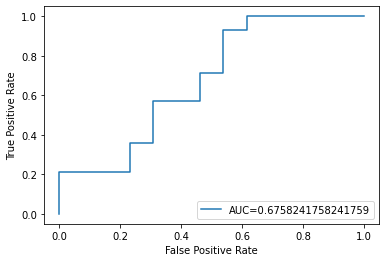

In [148]:
    classes_=[0,1]
    fpr, tpr, _ = skm.roc_curve(y_t2,  pred_agg2)
    auc = skm.roc_auc_score(y_t2,  pred_agg2)
    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()